In [32]:
import os
import warnings
warnings.filterwarnings('ignore')

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
os.chdir('drive/My Drive')

FileNotFoundError: ignored

The Case Study we are solving is Airbnb new user predictions from Kaggle. It has multiple data sets like train, test, sessions, age bucket, countries. So we shall analyse the features given in each dataset one by one.

#Eploratory Data Analysis (EDA)

##Train

In [35]:
!pip install phik

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
from datetime import datetime
import phik

Let us print first 5 rows of train data and see what it looks like.

In [37]:
train = pd.read_csv('train_users_2.csv')
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


We can see from above, there is only one numerical column all others are categorical. Also there are some NaN values. Before analysing each feature, we will just check how many columns have missing values

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

From above info, we can see that 2.1 lakh data points are there. And columns date_first_booking, age, first_affiliate_tracked are having null values. date_first_booking has more than 50% null values but as test data has all new users, all values will be null for this column. So we will drop this column anyway. Generally we drop features which have more null values. But here, we need to check if the existing non-null data is of use for us and decide whether to drop it or not.
Age feature has almost 45% null values. We need to see how we can impute these null values.

As there are many features and we know that not every feature given will be important. So we will first know what features are important in deciding the target variable i.e. country_destination and then perform analysis on those important features.

Since we can't use date features as is, we need to create new features from them. So initially we will remove them and plot the correlation matrix only with raw features available.

In [39]:

train_columns = [ 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser','country_destination']
correlation_matrix = train[train_columns].phik_matrix()

interval columns not set, guessing: ['age', 'signup_flow']


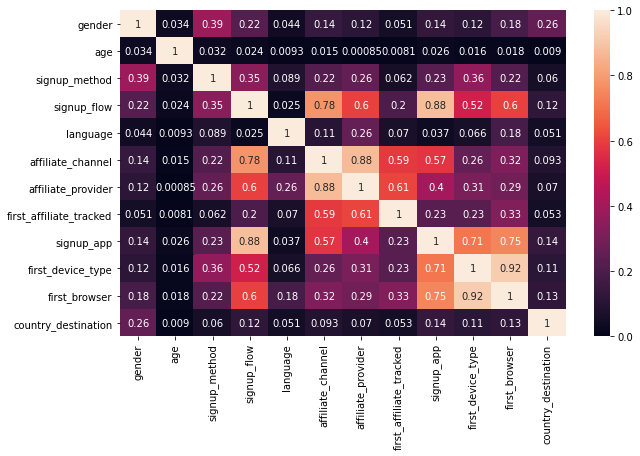

In [40]:
plt.figure(figsize=(10,6))
plot = sns.heatmap(correlation_matrix, vmin=0, vmax=1, annot=True)

From above plot, it is clear that no feature is actually important in deciding country_destination. 'Gender' feature has the highest value i.e. 0.26.

Next highest features are signup_app with 0.14, first_browser with 0.13, signup_flow with 0.12 and first_device_type with 0.11. 

Least correlated to target variable is 'age' feature followed by language and first_affiliate_tracked.

Also, 
- signup_app and affiliate_channel are highly correlated with signup_flow.
- affiliate_channel and affiliate_provider are correlated. 
- first_device_type and signup_app are correlated with first_browser.

There are other features with correlation score 0.5-0.6.


Now, we will create new features and see how they are related to country_destination.

In [41]:
def extract_weekday(format, datecolumn):
  weekdays = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
  day_of_week = [weekdays[datetime.strptime(str(x), format).weekday()] for x in datecolumn]
  return day_of_week

def extract_month(format, datecolumn):
  month = [calendar.month_name[datetime.strptime(str(x), format).month] for x in datecolumn]
  return month

def extract_year(format, datecolumn):
  years = [str(datetime.strptime(str(x), format).year) for x in datecolumn]
  return years

def extract_date(format, datecolumn):
  dates = [str(datetime.strptime(str(x), format).day) for x in datecolumn]
  return dates

def extract_month_year(datecolumn):
  month_year = [x.rsplit('-',1)[0] for x in datecolumn]
  return month_year

In [42]:
train['day_account_created'] = extract_weekday('%Y-%m-%d', train['date_account_created'])
train['month_account_created'] = extract_month('%Y-%m-%d', train['date_account_created'])
train['year_account_created'] = extract_year('%Y-%m-%d', train['date_account_created'])
train['account_created_date'] = extract_date('%Y-%m-%d', train['date_account_created'])
train['account_created_monthyear'] = extract_month_year(train['date_account_created'])

In [43]:
# train['day_first_active'] = extract_weekday('%Y%m%d%H%M%S', train['timestamp_first_active'])
# train['month_first_active']=extract_month('%Y%m%d%H%M%S', train['timestamp_first_active'])
# train['year_first_active']=extract_year('%Y%m%d%H%M%S', train['timestamp_first_active'])
# train['date_first_active'] = extract_date('%Y%m%d%H%M%S', train['timestamp_first_active'])

In [44]:
def difference_of_days(dac,tfa):
  dac_dt = datetime.strptime(str(dac), '%Y-%m-%d')
  tfa_dt = datetime.strptime(str(tfa), '%Y%m%d%H%M%S')
  no_of_days = dac_dt-tfa_dt
  return no_of_days.days


In [45]:
train['days_between_tfa_dac'] = train.apply(lambda x: difference_of_days(x.date_account_created,x.timestamp_first_active), axis=1)

In [46]:
train.head(2)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,day_account_created,month_account_created,year_account_created,account_created_date,account_created_monthyear,days_between_tfa_dac
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,Monday,June,2010,28,2010-06,465
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,Wednesday,May,2011,25,2011-05,731


In [48]:
train_columns = [x for x in train.columns if x not in ['id','date_account_created','timestamp_first_active','date_first_booking','country_destination']]
train_columns.append('country_destination')

interval columns not set, guessing: ['age', 'signup_flow', 'days_between_tfa_dac']


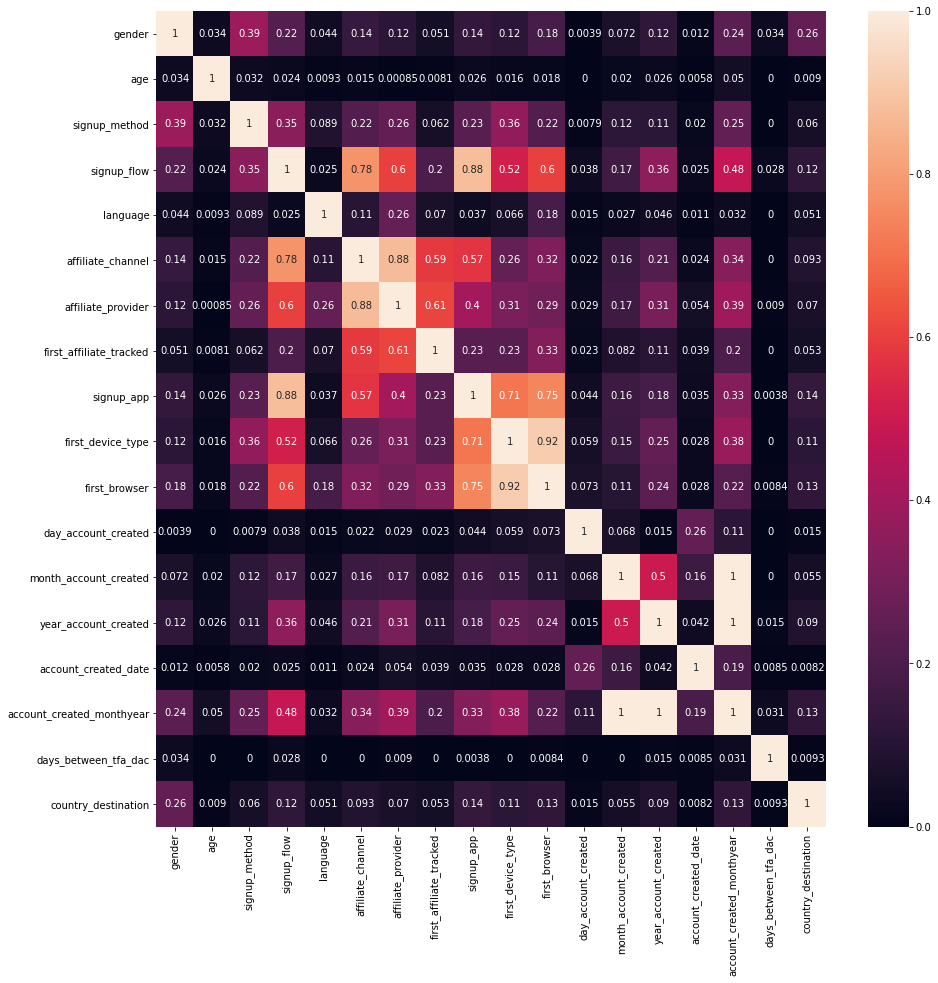

In [49]:
plt.figure(figsize=(15,15))
plot = sns.heatmap(train[train_columns].phik_matrix(), vmin=0, vmax=1, annot=True)

Among the newly created features from date_account_created, account_created_monthyear feature has maximum correlation with country_destination where as account_created_date has least. 

According to the heatmap generated, very less features are slightly important. All others are least important to the target variable.

So let us perform analysis on the features and see what insights can be drawn from them. 

Instead of dividing the analysis into Univariate, Bivariate and Multivariate, we will analyse feature wise and its relation with the target variable. Having said that, let us see how target variable i.e. 'country_destination' is distributed. 

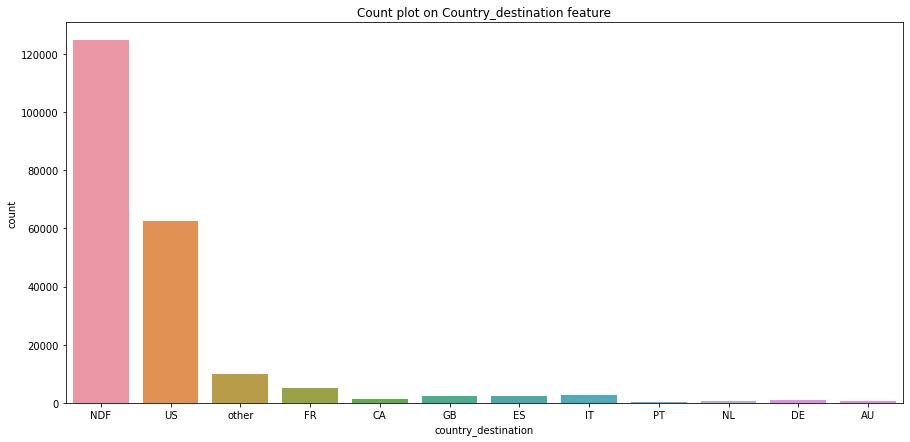

In [50]:
plt.figure(figsize=(15,7))
sns.countplot(x="country_destination", data=train).set_title('Count plot on Country_destination feature')
plt.show()

Seeing this, it is very clear that our data is highly imbalanced. More than half of the data points are NDF i.e. No Destination Found. It is obvious that not all users who sign up to Airbnb will book a travel. Or by the time data is taken, those users didn't book their first booking. They may do it later. 

And next highest is US. This is also a bit obvious because we have been told that all users are from US and as US itself is a big country and has many places to visit, most of the users prefer to book their travel inside US. Only those people who have a passion towards travelling and exploring the world will prefer to go to other countries. 

There is not much difference in counts of remaining countries with PT being the least. May be it has very less tourist attractions or it is a small country.

There is a huge imbalance in country_destination column with maximum being NDF and minimum being PT. There are ways to handle imbalance which we will see in modeling.

Now, we will go from starting. First is 'id' column. It is unique for each user and each row in train data corresponds to a user. 

Next comes date_account_created feature. It is in string format. So we need to change it to datetime for better analysis. If we don't change, there will be hundreds of categories for this column

###Date account created

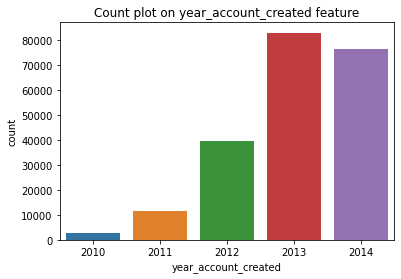

In [51]:
plot = sns.countplot(x="year_account_created", data=train, order=['2010','2011','2012','2013','2014']).set_title('Count plot on year_account_created feature')

Every year, Airbnb users count is increasing more than double. But in the above plot, from 2013 to 2014 count is decreased. This might be definitely because for 2014 data is not available for all the year. We will check till which date/month of 2014, data is available. Because if the count is less for the whole year, then there is a serious business problem to Airbnb which they will have to handle.

In [52]:
pd.to_datetime(train['date_account_created']).sort_values()

5        2010-01-01
6        2010-01-02
7        2010-01-03
9        2010-01-04
8        2010-01-04
            ...    
213058   2014-06-30
213059   2014-06-30
213060   2014-06-30
213044   2014-06-30
213450   2014-06-30
Name: date_account_created, Length: 213451, dtype: datetime64[ns]

As we can see, the data is available till June 30 2014. That is just half a year. 

Let us see how number of bookings done per year varied with count plot between year and whether a booking was done or not.

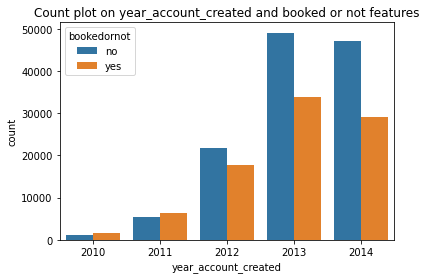

In [53]:
train['bookedornot'] = ['no' if x=='NDF' else 'yes' for x in train['country_destination']]
plot = sns.countplot(x="year_account_created", data=train, hue='bookedornot', order=['2010','2011','2012','2013','2014']).set_title('Count plot on year_account_created and booked or not features')

From above plot, year by year, ratio of users who didn't book to who booked a travel is increasing. If this continues, it will become a problem to address for Airbnb. A user created an account in Airbnb means that he wanted to travel/ make a booking but still didn't book any. This means he booked his travel through some other means (a competetior of Airbnb). This can be due to various reasons namely, Airbnb's suggestions are not suitable to the user, Cost of a booking is more in Airbnb compared to others etc. That is why they gave this competition in Kaggle to build a good recommendation system.

Airbnb should try to provide better customer experience such that number of users booked a year should exceed that of user who didn't book a travel

###Month-year of account creation

In [54]:
train['date_account_created'] = train['date_account_created'].apply(lambda x :datetime.strptime(x, '%Y-%m-%d'))
train.sort_values('date_account_created', inplace=True)

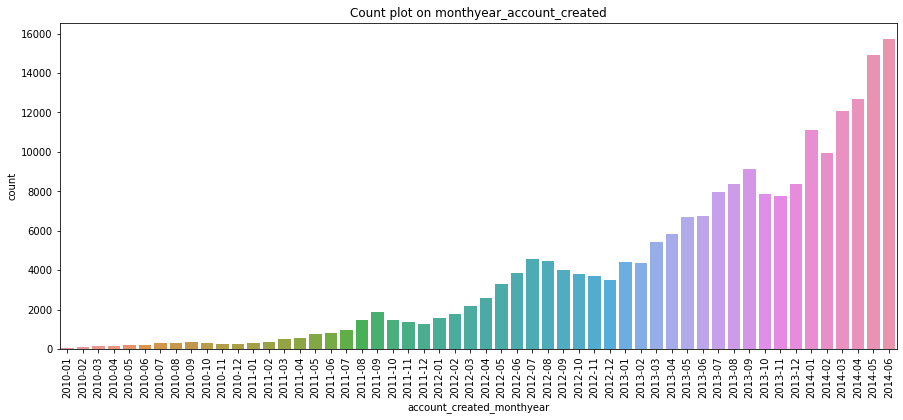

In [55]:
plt.figure(figsize=(15,6))
plot = sns.countplot(x="account_created_monthyear", data=train).set_title('Count plot on monthyear_account_created')
ticks = plt.xticks(rotation='vertical')

From above plot, it is evident that in August and September every year, more accounts are getting created. May be during those months, users prefer to go on a trip i.e. make a booking. 

Now let us see how ratio of bookings to non-bookings varied through this feature

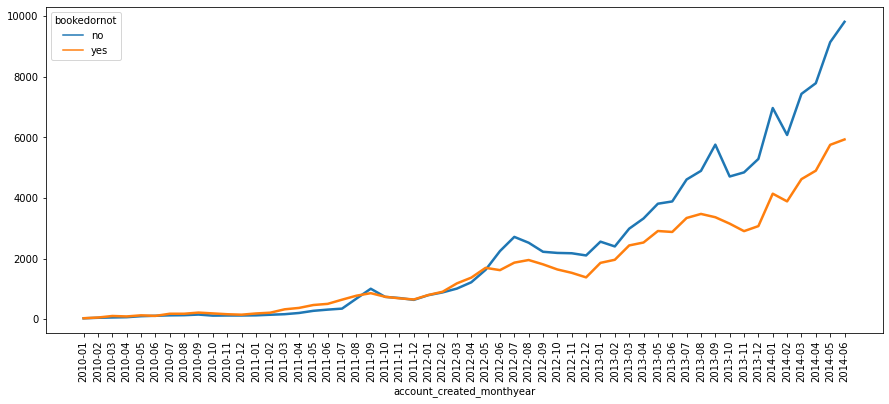

In [56]:
plt.figure(figsize=(15,6))
plot = sns.lineplot(data=pd.crosstab(train['account_created_monthyear'],train['bookedornot']), dashes=False, linewidth=2.5)
ticks = plt.xticks(rotation='vertical')

The gap between users who made a booking and those who didn't became very high in 2014 maximum being in june 2014. This means users who created their Airbnb accounts in 2014 are more likely not to make a booking. This can be due to lot of reasons that Airbnb can solve. But there is no rule that a user makes a booking soon after he creates an account. He might do it in future as well. And that is the reason the gap is more in the last months of data. 

Even though this feature has a good i.e. 0.13 correlation with country_destination, we can't use this is model because all the users first activity in test data starts from july 2014 and all the categories generated from test data for this feature will be unseen for the model.

###Date First Booking

Even Though we are going to drop this column, we can use the available data for our analysis. We can check if any trend in day/month of booking. Also we can see if there is any correlation between them with destination country. 

In [57]:
temp_train = train[~train['date_first_booking'].isna()]
temp_train['year_dfb'] = temp_train['date_first_booking'].apply(lambda x: x.split('-')[0])
temp_train = temp_train[temp_train['year_dfb']!='2014']

Let us see month of first booking has any trends. For us to compare monthly data, there should be balanced data for all months. Since we have 2014's data for first half, we will just exclude 2014 data and analyse it.  

In [58]:
temp_train['month_first_booking'] = [datetime.strptime(str(x), '%Y-%m-%d').month for x in temp_train['date_first_booking']]

counts_mfb = pd.crosstab(temp_train['country_destination'],temp_train['month_first_booking'])
counts_mfb.head()

month_first_booking,1,2,3,4,5,6,7,8,9,10,11,12
country_destination,,,,,,,,,,,,
AU,27,25,22,13,25,20,21,22,36,45,59,45
CA,31,33,54,75,100,104,113,125,91,66,71,56
DE,29,39,57,50,94,78,78,99,103,54,44,38
ES,53,85,109,140,179,186,174,165,138,106,55,53
FR,174,221,290,325,405,348,269,369,308,274,230,203


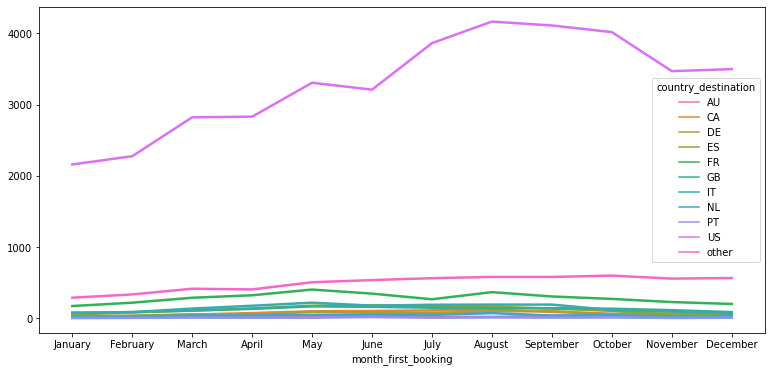

In [59]:
plt.figure(figsize=(13,6))
plot = sns.lineplot(data=counts_mfb.T, dashes=False, linewidth=2.5)
ticks = plot.set_xticks(range(1,13))
tickslbl = plot.set_xticklabels(calendar.month_name[1:])

From above line plot, US follows a peculiar trend through a year. Number of bookings done to US are increasing month by month with peak during August to October and there is a slight decrease in November and December as it is festive season and people prefer to stay home. There is a slight peak in May as school children will have summer break. 

One strong observation is there are more bookings to US in the second half of the year than the first half.

Bookings to remaining countries follow almost same distribution. Some countries have almost linear i.e. equal number of booking in all months. We will draw another plot to see clearly if any trends for countries other than US. 

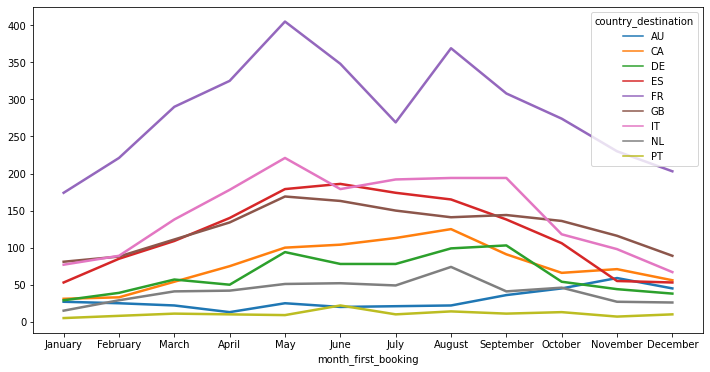

In [60]:
plt.figure(figsize=(12,6))
plot = sns.lineplot(data=counts_mfb.T.drop(['US','other'], axis=1), dashes=False, linewidth=2.5)
ticks = plot.set_xticks(range(1,13))
tickslbl = plot.set_xticklabels(calendar.month_name[1:])

After analysing the above plot, here are a few observations:

For most of the countries, the distribution followed a bell curve through the months. That means, starting from March and April till Septmeber, (i.e. middle months) there were more bookings compared to other months. This may be because children have holidays in the mid year and so parents may prefer to take them on a trip. 

For the country AU, the number of bookings increased in the second half of the year. 

After US, highest number of bookings are for France. It is obvious that France has many tourist attrctions. So, Airbnb can by default show some places from France to users.

Even though months can't play a major role in deciding which country a user will be going, we saw more bookings in middle months. May be Airbnb can give exciting offers and tour packages in other months to boost the number of bookings and attract users.

We can also see how the number of bookings varied through a week.

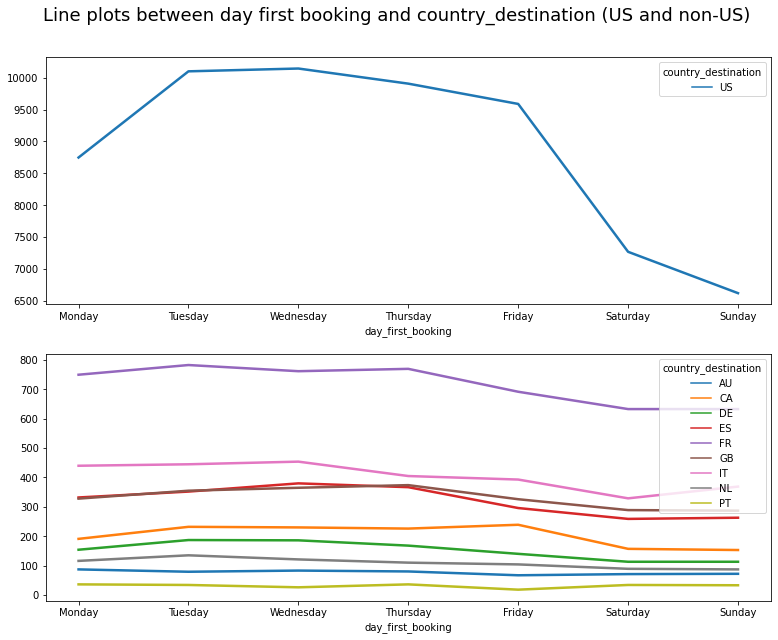

In [61]:
weekdays = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
temp_train = train[~train['date_first_booking'].isna()]
temp_train['day_first_booking'] = [datetime.strptime(str(x), '%Y-%m-%d').weekday() for x in temp_train['date_first_booking']]
temp_train_us = temp_train[temp_train['country_destination']=='US']
temp_train_nus = temp_train[(temp_train['country_destination']!='US') & (temp_train['country_destination']!='other')]
f, axes = plt.subplots(2, 1, figsize=(13,10))
# axes[0].figure(figsize=(13,6))
f.suptitle('Line plots between day first booking and country_destination (US and non-US)',y=0.95,size=18)#,verticalalignment='bottom')
plot1 = sns.lineplot(data=pd.crosstab(temp_train_us['day_first_booking'],temp_train_us['country_destination']), ax=axes[0], dashes=False, linewidth=2.5)
plot2 = sns.lineplot(data=pd.crosstab(temp_train_nus['day_first_booking'],temp_train_nus['country_destination']), dashes=False, ax=axes[1], linewidth=2.5)
ticks = plot1.set_xticks(range(0,7))
tickslbl = plot1.set_xticklabels(weekdays)
ticks = plot2.set_xticks(range(0,7))
tickslbl = plot2.set_xticklabels(weekdays)

From the below plot which is a line plot for countries other than US and other, there is not much interesting inferences from the above plot. Data is almost equally distributed through the week. There is just slight decrease in bookings on Saturdays and Sundays because people will book on a weekday to go on a trip in weekends. People who made a booking on weekend might have booked for Work related stay or for the upcoming weekend or may be a sudden plan.

In above plot, the same trend is present in bookings to US but the difference in bookings during weekends and weekdays is more. Sudden plans are less to US. This might be because there might be high demand for places in US that a user need to book in advance but not sudden.

Airbnb can provide some offers on weekends and also suggest some places in US such that bookings bookings to US in weekends will increase.

###Gender

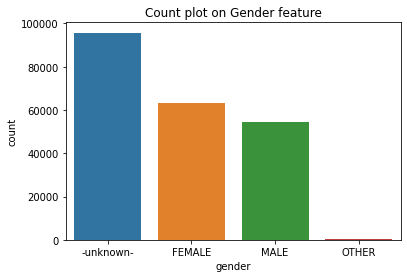

In [63]:
plot = sns.countplot(x='gender', data=train).set_title('Count plot on Gender feature')

Even though there are no null values in 'gender' feature, almost half of the values for gender is 'unknown'. Before thinking of handling these unknown genders, we will just see if there is any underlying relation between gender and country destination.

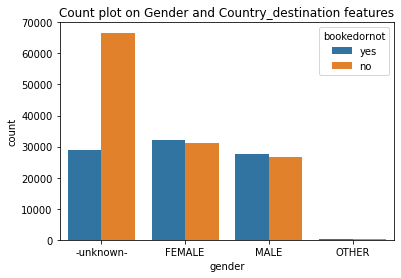

In [64]:
plot = sns.countplot(x='gender', data=train, hue='bookedornot').set_title('Count plot on Gender and Country_destination features')

If the gender is unknown, then there are more chances that there is no booking i.e. 'NDF'. This means users who are not providing their gender details are less likely to make a booking. Airbnb has to understand if this just missing data or users are not specifying gender while signup. If it is latter, then this is an interesting insight which can be used in recommender system.
This is why we got 0.26 correlation between gender and country_destination feature.

We analysed bookings to US separately and remaining countries separately for better visualization of plots. Countplot of users who made booking to US is equally distributed among different genders. 

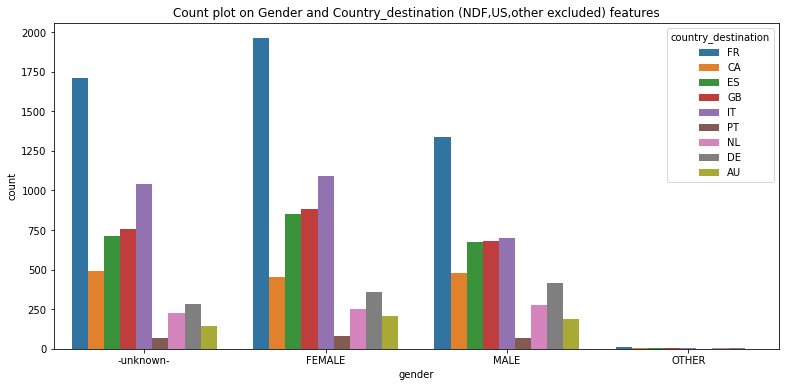

In [65]:
plt.figure(figsize=(13,6))
temp_data = train[(train['country_destination']!='US') & (train['country_destination']!='other') & (train['country_destination']!='NDF')]
plot = sns.countplot(x='gender', data=temp_data, hue='country_destination').set_title('Count plot on Gender and Country_destination (NDF,US,other excluded) features')

Distributions for all three major genders looks almost similar.

Female users are inclined towards France. It is may be because Paris (Capital of France) is famous for Fashion. Airbnb can by default suggest places in France to female users.

Men are less likely to go to Italy (IT) due to some unknown reasons.

For 'other' gender, even if there is a trend since the data is very less, it won't be of much for us.

###Age

In [66]:
train['age'].describe()

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

From above, it is clear that there are outliers in the data. Maximum age is 2014 while minimum is 1. We need to remove them to analyze because even the plots look distorted with these huge outliers.

In [67]:
train['age'] = [np.NaN if (x>120 or x<10) else x for x in train['age']]

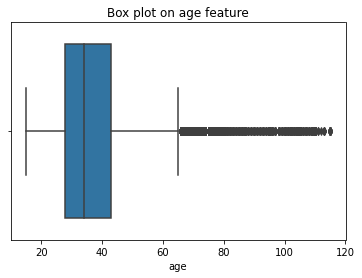

In [68]:
plot = sns.boxplot(x='age',data=train).set_title('Box plot on age feature')

There are less users between age 65 years and 120 years as it is obvious that old people are less likely to book a stay. Median age is around 35 years. 

Let us now see how age,gender and country destination are related.

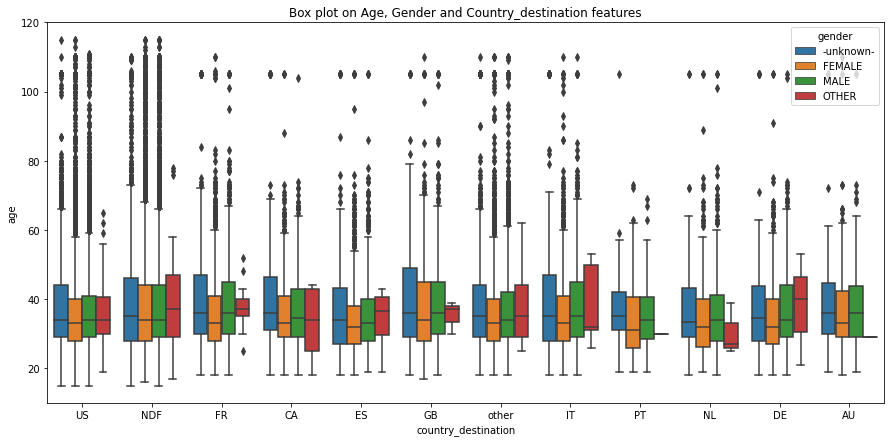

In [69]:
plt.figure(figsize=(15,7))
plot = sns.boxplot(x='country_destination', y='age' ,data=train, hue='gender').set_title('Box plot on Age, Gender and Country_destination features')

From above plot, there is not much to infer. Because for all the countries, age distribution is same. Also there is no preference pattern in age-gender to country destination. 

'Other' gender of age above 50 are less likely to have an account in Airbnb.

Old people are less likely to go to 'PT' and 'CA'.

Individually and combined, age and gender features are of not much use in deciding the country destination. May be if they are combined with other features available, can help.

####Signup method

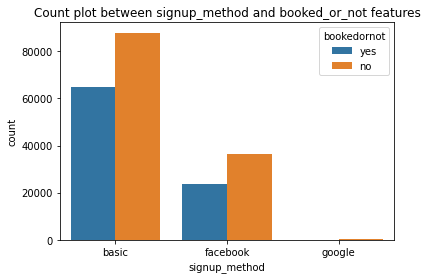

In [70]:
plot = sns.countplot(x='signup_method', data=train, hue='bookedornot').set_title('Count plot between signup_method and booked_or_not features')

Most of the users (around 70%) used basic signup method. Almost 30% of the users did facebook signup. Very less users used google signup. Signing up with facebook/google takes less time than the basic one because we will have to provide all the details in the basic method. But suprisingly, basic signup is more in number. 

singup_method has no trend in deciding the country_destination.

Let us plot and see only google signed up users because in above plot, there is only no-booking for google.

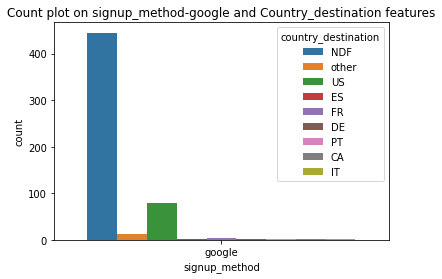

In [72]:
plot = sns.countplot(x='signup_method', data=train[train['signup_method']=='google'], hue='country_destination').set_title('Count plot on signup_method-google and Country_destination features')

If a user is signed up to Airbnb with google, he is more likely not to make a booking. Even though the reason is unknown, Airbnb should try to analyze this and see if there is anything they can do to improve beacuse 400 users is not a count that can be ignored.

###Signup flow

Even though signup flow is integer, the values present in the data are finite. So we will consider this feature to be categorical. For that, we will have to change this to string.

In [73]:
train['signup_flow'] = train['signup_flow'].astype('str')
temp_data['signup_flow'] = temp_data['signup_flow'].astype('str')

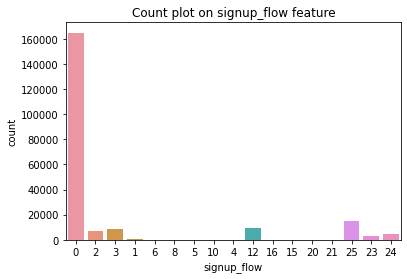

In [74]:
plot = sns.countplot(x='signup_flow', data=train).set_title('Count plot on signup_flow feature')

Around 75% of users have signup flow to be 0. Signup flow as given in Kaggle is "the page a user came to signup up from". It is not clearly mentioned about this feature. We will just analyze it as a black box. 

We will see relation between signup_flow and country. But since the data is highly imbalanced, we can't visualize properly. So we do it separately as below

The count plot of signup_flow 0 and country destination has similar distribution to that of original one. Not much useful.

Let us see signup_flow non-zero.

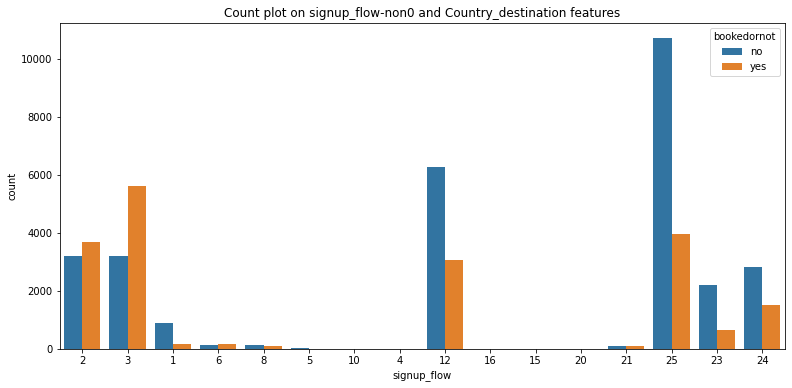

In [75]:
plt.figure(figsize=(13,6))
plot = sns.countplot(x='signup_flow', data=train[train['signup_flow']!='0'], hue='bookedornot').set_title('Count plot on signup_flow-non0 and Country_destination features')

If signup_flow is 25 or 23, then it is more likely that it belongs to NDF. For signup_flow 3, it is more likely that there is a booking.
Also for most of the categories, there is very less data. We can ignore them or just replace them with most occuring category (0 here).

Since the details of this feature are not clear, we can't provide any conclusions or suggestions to Airbnb based on this feature. 


###Signup app

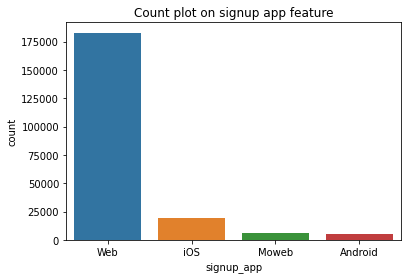

In [76]:
plot = sns.countplot(x='signup_app', data=train).set_title('Count plot on signup app feature')

Most of the users have used 'web' for signup. This may be because the app provided by Airbnb is not good or because mobile phones are not much popular at that time. So they can try to improve the app user interface and usability such that user can comfortably use app for bookings.



Generally apps are said to be more comfortable to users. But in this case, it is opposite. So Airbnb can focus on improving apps than web.

There is no particular trend to this feature in deciding country_destination.

###First device type

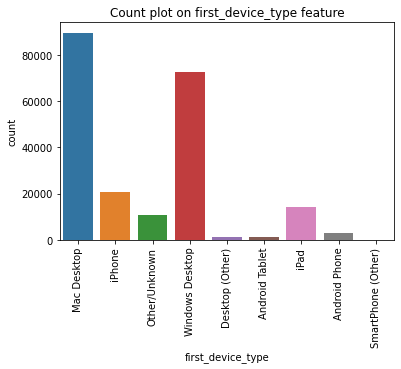

In [82]:
plot = sns.countplot(x='first_device_type', data=train).set_title('Count plot on first_device_type feature')
ticks = plt.xticks(rotation='vertical')

Almost 80% of users are using Mac Desktop and Windows Desktop with Mac taking a bit higher position. This is why users signup app was mostly web. Because apps are generally used in phones. May be smart phones are not much popular by that time (2013,2014 etc) or Airbnb app is not much popular by then. If it is the latter reason, Airbnb should focus on mobile applications more. Also most of the users used apple products(Mac,iPhone,iPad) etc as mentioned in signup app. 

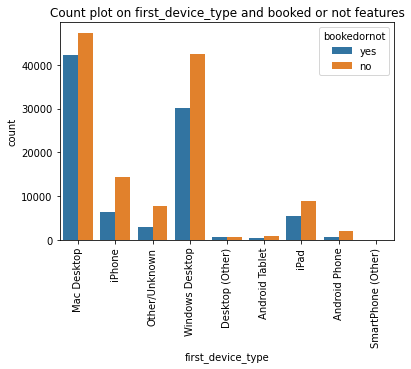

In [83]:
plot = sns.countplot(x='first_device_type', hue='bookedornot' ,data=train).set_title('Count plot on first_device_type and booked or not features')
ticks = plt.xticks(rotation='vertical')

This may be because the count is less but there is a small inference from above. Among the users whose first device is mobile i.e. iPhone or Android phone, then only 30% users made a booking. Also ratio to non-bookings to bookings is less in Mac Desktop than Windows desktop. That means Mac users are a bit more likely to make a booking compared to Windows users. 

We will now see if users using a particular device type have any inclination towards any country.

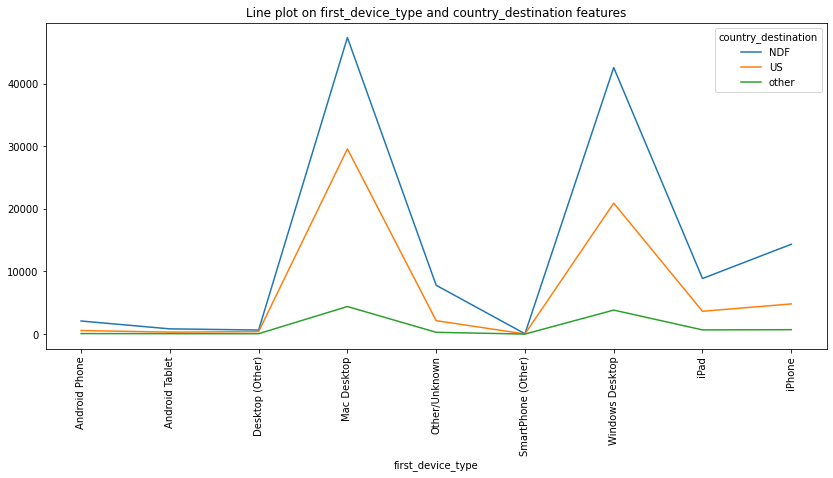

In [ ]:
plt.figure(figsize=(14,6))
temp_data = train[(train['country_destination']=='US') | (train['country_destination']=='other') | (train['country_destination']=='NDF')]
plot = sns.lineplot(data=pd.crosstab(temp_data['first_device_type'], temp_data['country_destination']), dashes=False).set_title('Line plot on first_device_type and country_destination features')
ticks = plt.xticks(rotation='vertical')

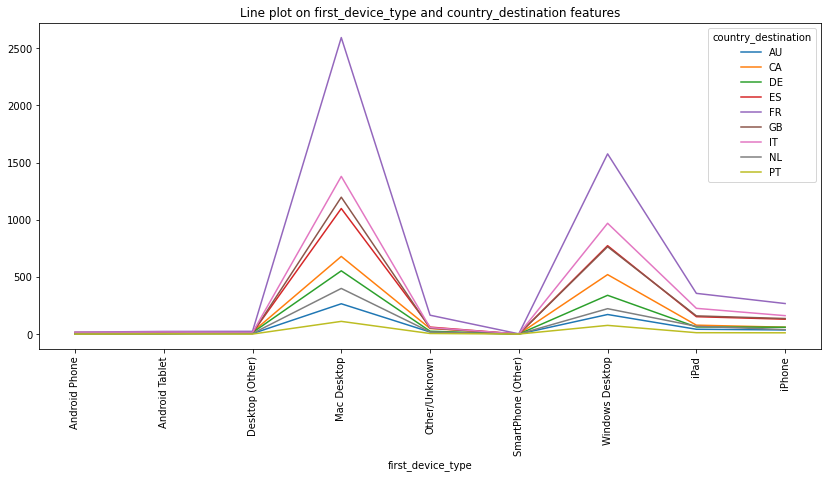

In [ ]:
plt.figure(figsize=(14,6))
temp_data = train[(train['country_destination']!='US') & (train['country_destination']!='other') & (train['country_destination']!='NDF')]
plot = sns.lineplot(data=pd.crosstab(temp_data['first_device_type'], temp_data['country_destination']), dashes=False).set_title('Line plot on first_device_type and country_destination features')
ticks = plt.xticks(rotation='vertical')

The ratio to france and other countries is almost same in all device types except in Mac. Mac users are a bit more likely to book to France (FR).

##Sessions

In [84]:
from collections import Counter

In [85]:
sessions = pd.read_csv('sessions.csv')
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


This sessions dataset is user behaviour relating to bookings on Airbnb. There are multiple sessions for a user and session details like action, action type, device type, seconds elapsed for that action/session are given. We can create features from this dataset which may be helpful in predicting the country destinations. Before doing that, let us perform basic analysis on the given columns.  

In [86]:
len(set(sessions['action_detail'])), len(set(sessions['action']))

(156, 360)

It is clear that there are 156 unique action_detail and 360 action available in this sessions dataset. These many features are very hard to visualize using plots. So we will see them numerically and others with plots.

In [87]:
Counter(sessions['action_detail']).most_common(10)

[('view_search_results', 1776885),
 ('p3', 1376550),
 (nan, 1126204),
 ('-unknown-', 1031141),
 ('wishlist_content_update', 706824),
 ('user_profile', 656839),
 ('change_trip_characteristics', 487744),
 ('similar_listings', 364624),
 ('user_social_connections', 336799),
 ('update_listing', 269779)]

Highest number of sessions recorded for 'view_search_results' action_detail. This is obvious because a user opens the Airbnb site/app and searches for places where he/she wants to go. Airbnb should try to reduce this by suggesting apt places for users such that user doesn't need to search for places but select from our recommendations.

'wishlist_content_update' is the next highest known action_detail. This shows that users are actually updating their wishlist more frequently. But unfortunately number of bookings done are less compared to NDF. Airbnb need to understand the relation between number of times a user is updating wishlist content and whether he/she made a booking or not.

In [88]:
Counter(sessions['action']).most_common(10)

[('show', 2768278),
 ('index', 843699),
 ('search_results', 725226),
 ('personalize', 706824),
 ('search', 536057),
 ('ajax_refresh_subtotal', 487744),
 ('update', 365130),
 ('similar_listings', 364624),
 ('social_connections', 339000),
 ('reviews', 320591)]

Action and Action detail columns look almost similar. But in action_detail, unknown and nan values accounted in the top 10 most occuring categories. 

####Action type

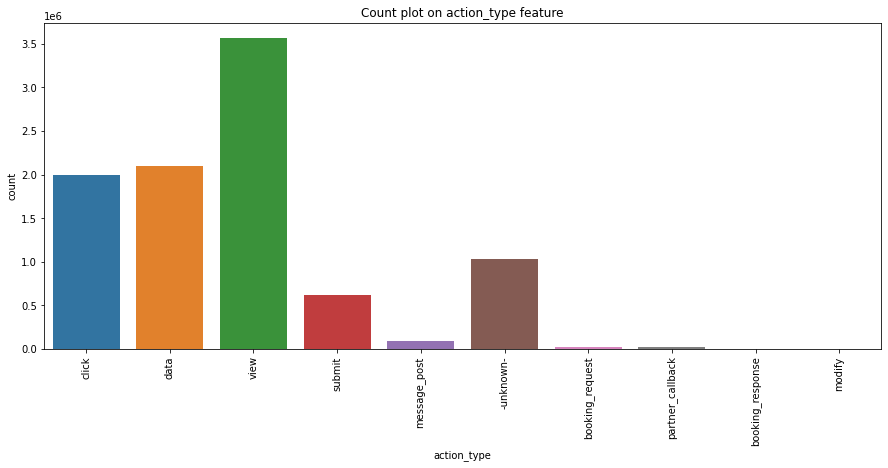

In [89]:
plt.figure(figsize=(15,6))
plot = sns.countplot(x='action_type', data=sessions).set_title('Count plot on action_type feature')
ticks = plt.xticks(rotation='vertical')

There are four major action types click, data, view, submit among which viewing count is more. Others are comparitively less in number but may be of some use because there is booking request and booking response among them. 

A point to note here is, the sessions dataset has data of users from both train and test data. And test data has new users.  

####Device type

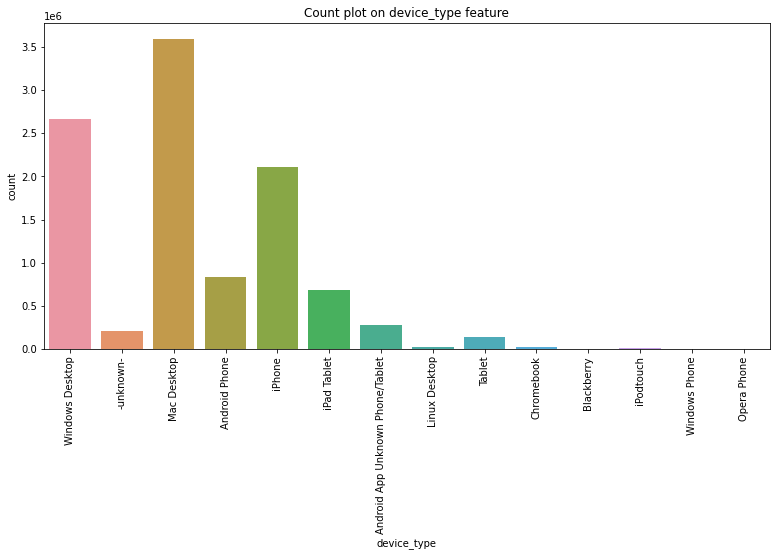

In [90]:
plt.figure(figsize=(13,6))
plot = sns.countplot(x='device_type', data=sessions).set_title('Count plot on device_type feature')
ticks = plt.xticks(rotation='vertical')

Most of the sessions are recorded in apple products like Mac desktop, iPhone, iPad tablet etc. Next is Windows desktop and android phones. Others are very less in number. For us to know if this helps in deciding our country destination, we need to merge and create new features.

####Seconds elapsed

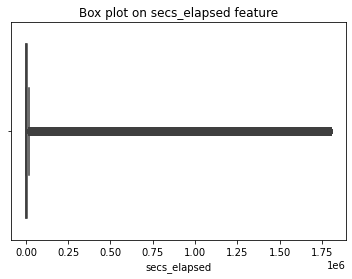

In [91]:
plot = sns.boxplot(x='secs_elapsed', data=sessions).set_title('Box plot on secs_elapsed feature')

There seems to be so many outliers for secs_elapsed column. A session recorded for 1 million seconds is not normal. So since it is difficult to understand from plot, we will understand from data itself.

In [92]:
sessions['secs_elapsed'].describe()

count    1.043171e+07
mean     1.940581e+04
std      8.888424e+04
min      0.000000e+00
25%      2.290000e+02
50%      1.147000e+03
75%      8.444000e+03
max      1.799977e+06
Name: secs_elapsed, dtype: float64

From above values, median is around 1000 seconds which is normal. Since there are outliers only on the upper side of the values, we will just crop values which are above boxplot maximum (i.e. >Q3+(1.5*IQR)) and see how plot looks. 

In [93]:
threshold = 8444+(1.5*(8444-229))


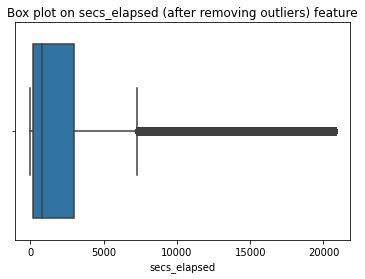

In [94]:
sessions_new = sessions[sessions['secs_elapsed']<threshold]
plot = sns.boxplot(x='secs_elapsed', data=sessions_new).set_title('Box plot on secs_elapsed (after removing outliers) feature')

Now, plot looks better with some outliers which might be of some meaning. 75% of sessions have seconds elapsed below 4000s. 50% of sessions take below 1000 seconds which is natural. Out point of interest is sessions that are taking more time and relation between time elapsed with bookings.

We can also see how seconds elapsed is related to action type.

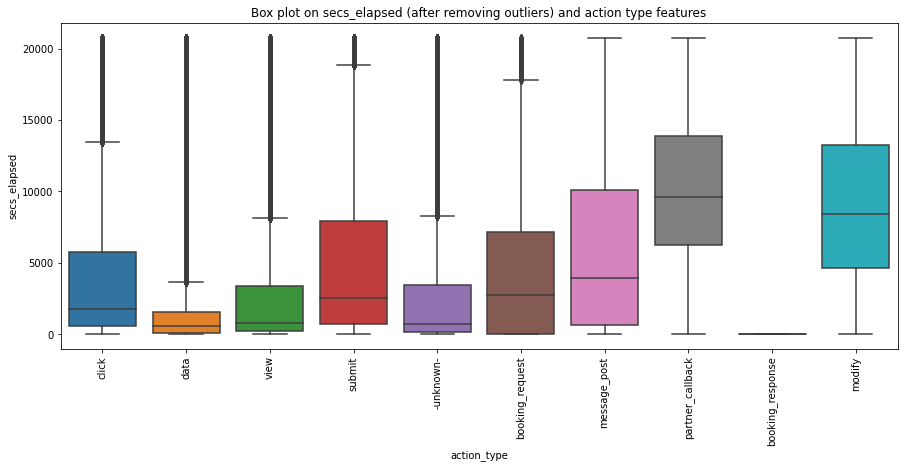

In [95]:
plt.figure(figsize=(15,6))
plot = sns.boxplot(x='action_type', y='secs_elapsed', data=sessions_new).set_title('Box plot on secs_elapsed (after removing outliers) and action type features')
ticks = plt.xticks(rotation='vertical')

Viewing has its 75% of seconds elapsed in low range i.e. below 4000 seconds. Also there are some sessions that lasted for almost 20k seconds. There might be some relation between this seconds elapsed for each action type and bookings like users who spent a lot of time in viewing might be interested in making a booking and vice versa. And booking request has 75% values below 10k seconds. So this might be an indication that booking request is taking long time which Airbnb can try to reduce for better user experience.

We will create new features from this dataset and see how they are related to country_destination.

In [96]:
mean_elapsed_times = sessions_new.groupby('user_id')['secs_elapsed'].mean().to_dict()
train['mean_session_time'] = [mean_elapsed_times.get(x,0) for x in train['id']]
train['mean_session_time'].replace(0,train['mean_session_time'].mean(), inplace=True)

In [97]:
actions_per_user = sessions_new.groupby('user_id').count()['action'].to_dict()
train['actions_per_user'] = [actions_per_user.get(x,0) for x in train['id']]
train['actions_per_user'].replace(0,train['actions_per_user'].mean(), inplace=True)

In [98]:
total_elapsed_times = sessions_new.groupby('user_id')['secs_elapsed'].sum().to_dict()
train['total_session_time'] = [total_elapsed_times.get(x,0) for x in train['id']]
train['total_session_time'].replace(0,train['total_session_time'].mean(), inplace=True)

In [100]:
groups = sessions_new.groupby('user_id')
vals=[]
for name,group in groups:
  try:
    x = group[group['secs_elapsed']==group['secs_elapsed'].max()][['action_type', 'secs_elapsed']].values
    if x[0][0]:
      vals.append((name,x[0][0],x[0][1]))
    else:
      vals.append((name,'NA',x[0][1]))
  except:
    continue
df = pd.DataFrame(vals)

In [102]:
df = df.set_index(0)
df.head()

,1,2
0,,
00023iyk9l,view,20438.0
0010k6l0om,view,17450.0
001wyh0pz8,view,20501.0
0028jgx1x1,click,15904.0
002qnbzfs5,-unknown-,20665.0


In [105]:
train['max_elapsed_action'] = [df.loc[x][1] if x in df.index else 'NA' for x in train['id']]

In [114]:
train['max_elapsed_time'] = [df.loc[x][2] if x in df.index else 0 for x in train['id']]

In [115]:
train_columns = [x for x in train.columns if x not in ['id','date_account_created','timestamp_first_active','date_first_booking','country_destination']]
train_columns.append('country_destination')

interval columns not set, guessing: ['age', 'days_between_tfa_dac', 'mean_session_time', 'actions_per_user', 'total_session_time', 'max_elapsed_time']


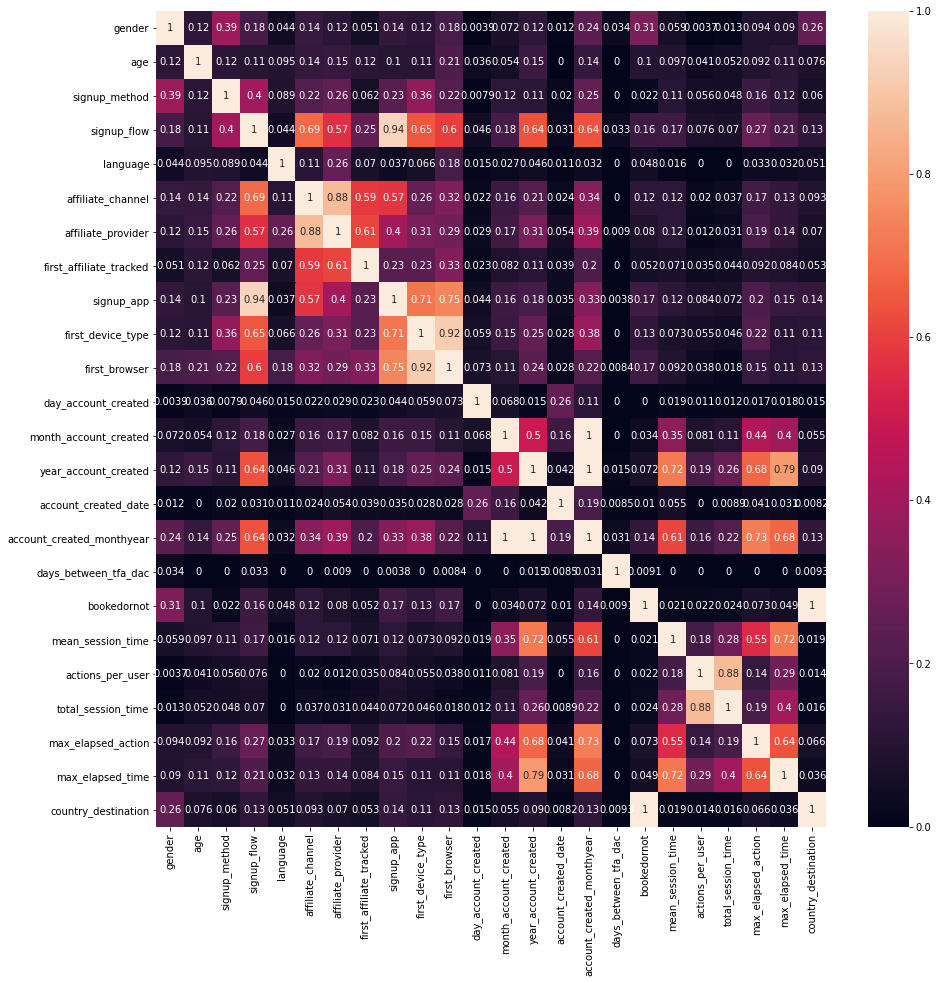

In [116]:
plt.figure(figsize=(15,15))
plot = sns.heatmap(train[train_columns].phik_matrix(), vmin=0, vmax=1, annot=True)

The newly added features from sessions dataset are not much correlated with country_destination feature. This might be because for 65% of the users in train dataset, there is no data in sessions dataset.

We can impute these features while building the model.

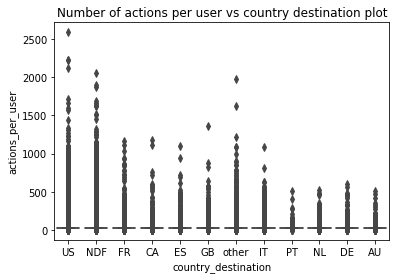

In [142]:
plot = sns.boxplot(x='country_destination',y='actions_per_user', data=train[train['actions_per_user']!=train['actions_per_user'].mean()]).set_title('Number of actions per user vs country destination plot')

Almost all the values for action per user lied below 50. But from the users who had more sessions, for US, NDF and other, number of actions/sessions went up to 2000. But for other countries, it is less. That means users whose country destination belong to US, NDF, other are spending more time on Airbnb. This might be because they had to searh more i.e. they didn't find what they are searching for easily. A point to note here is that we are talking about very few users. All others have same range of values. 

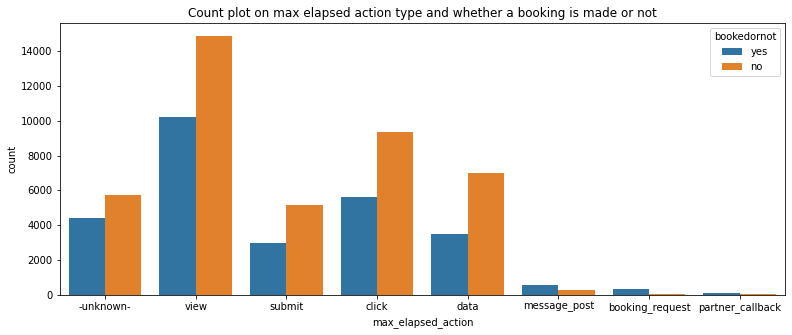

In [132]:
train_sessions = train[train['max_elapsed_action']!='NA']
plt.figure(figsize=(13,5))
plot = sns.countplot(data=train_sessions,x='max_elapsed_action', hue='bookedornot').set_title('Count plot on max elapsed action type and whether a booking is made or not')

Even though the counts are less, message_post and booking_request tells us that if the maximum elapsed action type is among those then it is more likely that a booking happened. Other all action types are almost same with booking to non-booking ratios.

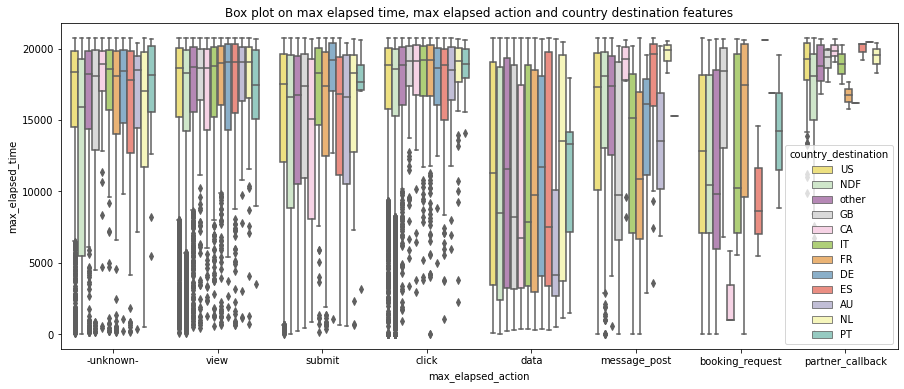

In [133]:
plt.figure(figsize=(15,6))
plot = sns.boxplot(x='max_elapsed_action',y='max_elapsed_time', data=train_sessions, hue='country_destination',palette="Set3_r").set_title('Box plot on max elapsed time, max elapsed action and country destination features')

There is some points to note from above. Viewing time is almost same for all countries. But for other than US, NDF, other, all others have max elapsed viewing time more. There are less users with less viewing time. That means users are spending more time in viewing to book a travel to countries other than US. 

And booking request time is very less for Canada. Message post time is very high for NL. Like this there are some underlying trends for these features which might be useful in models.

##Countries

In [126]:
countries = pd.read_csv('countries.csv')
countries.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


Countries dataset has data of each country present in the train data (target variable) like its latitude and longitude, its distance in kilometer from US (since all users are from US), area of the country, language distance from english to the language spoken in that country.

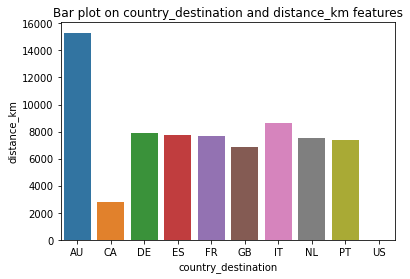

In [127]:
plot = sns.barplot(x='country_destination', y='distance_km', data=countries).set_title('Bar plot on country_destination and distance_km features')

Above is a bar plot of countries and their distance from US in km. Australia is far from US which means users will be less likely to book to AU. Canada is near to US compared to other countries available. But number of bookings made to CA is also less (from train data). This might be because there are no tourist attractions or not much companies/industries in Canada or it might be a small country etc. All other countries are almost of same distance from US. 


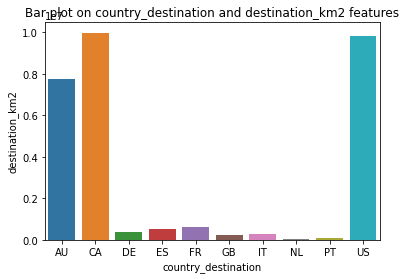

In [128]:
plot = sns.barplot(x='country_destination', y='destination_km2', data=countries).set_title('Bar plot on country_destination and destination_km2 features')

There is a huge difference in areas/sizes of countries. Only US, Canada and Australia are big and of same size. All other countries are very small in size i.e. almost 10% of the big countries.

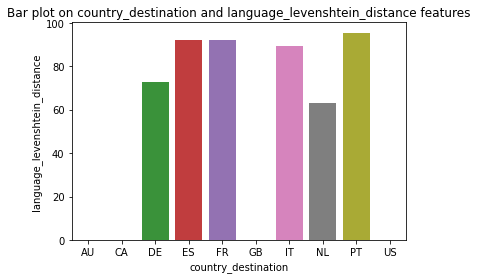

In [129]:
plot = sns.barplot(x='country_destination', y='language_levenshtein_distance', data=countries).set_title('Bar plot on country_destination and language_levenshtein_distance features')

From above, we know that in Australia, Canada, Great Britain, US, english is spoken (since language distance is given from English). All other country's languages are almost equidistant from english.  

##Age Bucket 

In [130]:
age_bkt = pd.read_csv('age_gender_bkts.csv')
age_bkt.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


The Age gender bucket dataset consists of population (in thousands) in each country for particular age bucket and age in year 2015.

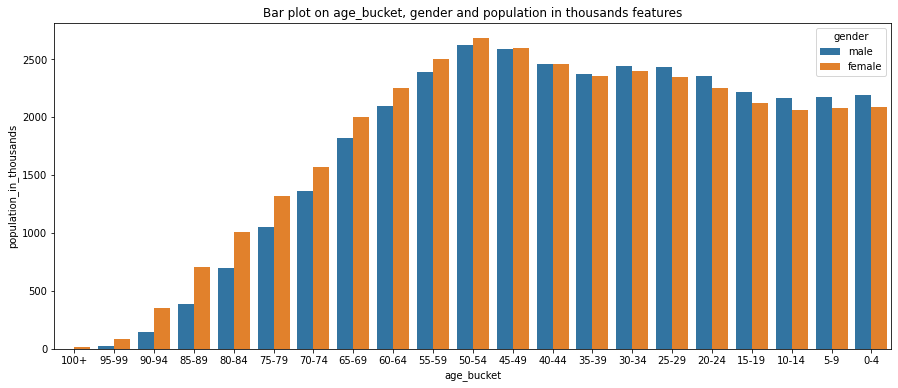

In [131]:
plt.figure(figsize=(15,6))
plot = sns.barplot(x='age_bucket', y='population_in_thousands', hue='gender', data=age_bkt, ci=0).set_title('Bar plot on age_bucket, gender and population in thousands features')

Above is the plot between population of male and female present in particular age buckets in all the countries given. Even though the ratio to males and females are almost same through out age buckets, there is an interesting thing to note. In initial ages, males are a bit higher in number than females but in old ages, the females are higher. Men are dying sooner than women. There might be an underlying cause for the same. Also population in age bucket 50-54 are high compared to other buckets. 

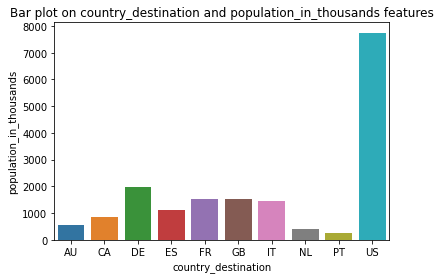

In [ ]:
plot = sns.barplot(x='country_destination', y='population_in_thousands', data= age_bkt ,ci=0).set_title('Bar plot on country_destination and population_in_thousands features')

As per given data, in 2015, US is the most populous country and Portugese (PT) is the least populous. Population and size of countries are almost in same ratio except for Australia and Canada. Even though they have more area/size population is less which means they are sparsely populated countries. 

###Conclusion

This is all for EDA (Exploratory Data Analysis). We have analysed all the given datasets and drew some interesting insights which might help in increasing business for Airbnb. 

From above analysis and plots we can't conclusively say that particular feature is useful/important. There is no clear separation between the user's selection of different countries. Thats the reason Airbnb has asked us to give atmost 5 possible destinations per user such that they can suggest all of them instead of only one country. 

We will see Data processing (like imputing missing values, removing very rare occuring categories etc) and Feature Engineering (like creating new features from available features and also from other datasets given viz. sessions, age_gender_bucket etc) next.